## Introduction

Project Mission - 

The increasing number of criminal incidents in the last couple of days in the United States has been a driving factor
for us to select this topic. We have identified this dataset as we plan on finding some of the root causes of what the 
numbers from these datasets show the relationships between demographic data and criminal. We are planning to start 
with finding the average of criminal offense region wise and then we are merging another dataset and will be cleaning 
data as part of our warm up question. With that completed, our next attempt would be towards finding the influential 
factors that contribute towards the crime that happen. Finally, our stretch question will be to utilize our analysis 
to implement additional libraries or technologies in analysis data from demographic dataset as well as the weather. 
To achieve the purpose of building analysis model, we could explore the statistic models, which is a Python module.


Contributors -
Ananya Mishra
Arjun Berry
Jayanti Trivedi
Tianzhu Wang
Xinying Du


Duration - July 2016 - August 2016



## Import the libraries

In [1]:
from pandas import Series,DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import numpy as np
import datetime
from pandas_datareader import data
from pandas_datareader import wb
import seaborn as sns
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
import plotly.plotly as py
# Cufflinks binds plotly to pandas dataframes in IPython notebook.
import cufflinks as cf

In [2]:
#%matplotlib
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Function to convert columns to numeric data

In [3]:
def convert_numeric(crime_data,col_name):
    crime_data[col_name]=crime_data[col_name].convert_objects(convert_numeric=True)
    return crime_data

## Function to format crime data

In [4]:
def format_crime_data(crime_data):
    crime_data=crime_data.rename(columns=lambda x: x.strip())
    crime_data=crime_data.fillna(0)
    columns_list= crime_data.columns.tolist()
    for column in columns_list:
        if column not in (['State','County']):
            for element in crime_data[column]:
                element = pd.to_numeric(element)
    crime_data['Rape']=crime_data['Rape (revised definition)']+crime_data['Rape (legacy definition)']
    crime_data['sum_of_crimes']=crime_data['Violent Crime']+crime_data['Murder and nonnegligent manslaughter']+\
    crime_data['Rape']+crime_data['Robbery']+crime_data['Aggravated assault']+crime_data['Poverty Crime']+\
    crime_data['Burglary']+crime_data['Larceny-theft']+crime_data['Motor vehicle theft']+crime_data['Arson3']
    return crime_data

## Function to add county code to crime and police data

In [5]:
def add_county_code(df):
    # format df to prepare for merge
    df['State']=df['State'].str.split('-').str.get(0).str.strip().str.lower()
    df['County']=df['County'].str.lower()+' county'
    
    # add state abbreviation to df based on State name
    ab_states=pd.read_csv('USStates.txt',header=None,names=['State','ab','area','pop'])
    ab_states['State']=ab_states['State'].str.lower()
    df=df.merge(ab_states)
    
    # add county code based on the state abb and county name
    county_code = pd.read_csv('national_county.txt',header=None, names=['ab','c1','c2','County','H'],dtype=str)
    county_code['code']=county_code['c1']+county_code['c2']
    county_code['County']=county_code['County'].str.lower()
    df=pd.merge(df, county_code, on=['County','ab'],how='left')
    return df

## Read Data Files

In [6]:
# read crime data and formating crime data
crime_data = pd.read_csv('CrimeDate2014_Updated.csv',skiprows = 4,skip_footer = 8,thousands=',',na_values=['0',0,' '], engine='python')
crime_data.columns = ['State', 'County', 'Violent Crime' , 'Murder and nonnegligent manslaughter', 'Rape (revised definition)', 'Rape (legacy definition)', 'Robbery', 'Aggravated assault', 'Poverty Crime', 'Burglary', 'Larceny-theft','Motor vehicle theft', 'Arson3']
crime_data = format_crime_data(crime_data)
crime_data = add_county_code(crime_data)

# read police data and formating police data
police_data = pd.read_csv('Police_2014.csv',skiprows=3,skip_footer=1,thousands=',', engine='python')
police_data = add_county_code(police_data)
police_data = police_data.ix[:, ['code', 'police']]
police_data.columns = ['code', 'police']

# read other predictor variables and save useful columns
population = pd.read_csv('PopulationEstimates.csv', usecols=[0,3], header=None, skiprows=2,thousands=',',dtype=str,na_values=['0',0,' '])
population.columns = ['code', 'population']

#
unem = pd.read_csv('Unemployment.csv',usecols =[0,3], header=0,skiprows=6,thousands=',',dtype=str,na_values=['0',0,' '])
unem.columns = ['code', 'unem']

#
poverty = pd.read_csv('PovertyEstimates.csv',usecols = [0,3],header=0,skiprows=2,thousands=',',dtype=str,na_values=['0',0,' '])
poverty.columns = ['code', 'poverty']

#
education = pd.read_csv('Education.csv',usecols=[0,1],header=0,skiprows=4,thousands=',',dtype=str,na_values=['0',0,' '])
education.columns = ['code', 'education']

# Till here we are good to go ....... Check from below - 

In [7]:
crime_data.head()

,State,County,Violent Crime,Murder and nonnegligent manslaughter,Rape (revised definition),Rape (legacy definition),Robbery,Aggravated assault,Poverty Crime,Burglary,...,Arson3,Rape,sum_of_crimes,ab,area,pop,c1,c2,H,code
0,alabama,autauga county,68.0,2.0,8.0,0.0,6.0,52.0,414.0,170.0,...,0.0,8.0,964.0,AL,50744,4485000,01,001,H1,01001
1,alabama,baldwin county,98.0,0.0,4.0,0.0,18.0,76.0,662.0,230.0,...,0.0,4.0,1520.0,AL,50744,4485000,01,003,H1,01003
2,alabama,bibb county,4.0,0.0,1.0,0.0,0.0,3.0,82.0,42.0,...,0.0,1.0,172.0,AL,50744,4485000,01,007,H1,01007
3,alabama,blount county,90.0,0.0,6.0,0.0,1.0,83.0,923.0,311.0,...,0.0,6.0,2026.0,AL,50744,4485000,01,009,H1,01009
4,alabama,calhoun county,15.0,0.0,3.0,0.0,1.0,11.0,471.0,200.0,...,0.0,3.0,972.0,AL,50744,4485000,01,015,H1,01015


In [8]:
police_data.head()

,code,police
0,01001,62
1,01005,11
2,04003,181
3,04001,67
4,05007,227


In [9]:
population.head()

,code,population
0,01000,"4,846,411"
1,01001,"55,290"
2,01003,"199,713"
3,01005,"26,815"
4,01007,"22,549"


In [10]:
unem.head()

,code,unem
0,01011,8.9
1,01013,8.6
2,01015,8.0
3,01017,6.7
4,01019,5.8


In [11]:
poverty.head()

,code,poverty
0,01001,"7,204"
1,01003,"25,696"
2,01005,"5,943"
3,01007,"3,666"
4,01009,"10,000"


In [12]:
education.head()

,code,education
0,1005,25.4
1,1007,22.1
2,1009,21.9
3,1011,34.5
4,1013,23.4


## Merge all data files together

In [13]:
crime = pd.merge(crime_data, police_data, on='code', how='left')\
    .merge(population, on='code', how='left')\
    .merge(unem, on='code', how='left')\
    .merge(poverty, on='code', how='left')\
    .merge(education, on='code', how='left')

crime=crime.dropna()
crime=crime[crime['sum_of_crimes']!=0]

pop=crime['population'].str.replace(',','').astype(float)
edu=crime['education'].str.replace(',','').astype(float)
pov=crime['poverty'].str.replace(',','').astype(float)

crime.head()

,State,County,Violent Crime,Murder and nonnegligent manslaughter,Rape (revised definition),Rape (legacy definition),Robbery,Aggravated assault,Poverty Crime,Burglary,...,pop,c1,c2,H,code,police,population,unem,poverty,education
34191,florida,alachua county,572.0,1.0,50.0,0.0,78.0,443.0,2086.0,634.0,...,15313000,12,001,H1,12001,568.0,"256,518",5.2,"52,756",8.2
34235,florida,calhoun county,17.0,0.0,3.0,0.0,0.0,14.0,76.0,30.0,...,15313000,12,013,H1,12013,29.0,"14,511",6.9,"2,800",26.7
34256,georgia,bartow county,328.0,2.0,0.0,21.0,24.0,281.0,2367.0,638.0,...,7637000,13,015,H1,13015,228.0,"101,795",7.1,"14,398",18.7
65187,georgia,baldwin county,189.0,1.0,0.0,4.0,3.0,181.0,600.0,137.0,...,7637000,13,009,H1,13009,120.0,"45,822",8.7,"11,809",17.5
71430,idaho,ada county,184.0,0.0,65.0,0.0,2.0,117.0,843.0,191.0,...,1290000,16,001,H1,16001,425.0,"426,847",4.2,"48,083",6.2


# Time for Analysis

## Which state has the highest criminal activities in US ?

In [14]:
sum_by_state=crime.groupby('State').sum()['sum_of_crimes']
highest=sum_by_state[sum_by_state==sum_by_state.max()]
print('{} has highest criminal activities that is {} crimes in total in 2014.'.format(str.capitalize(highest.index.values[0]),int(highest[0])))

Georgia has highest criminal activities that is 6968 crimes in total in 2014.


## The top 3 states with highest average criminal offenses.

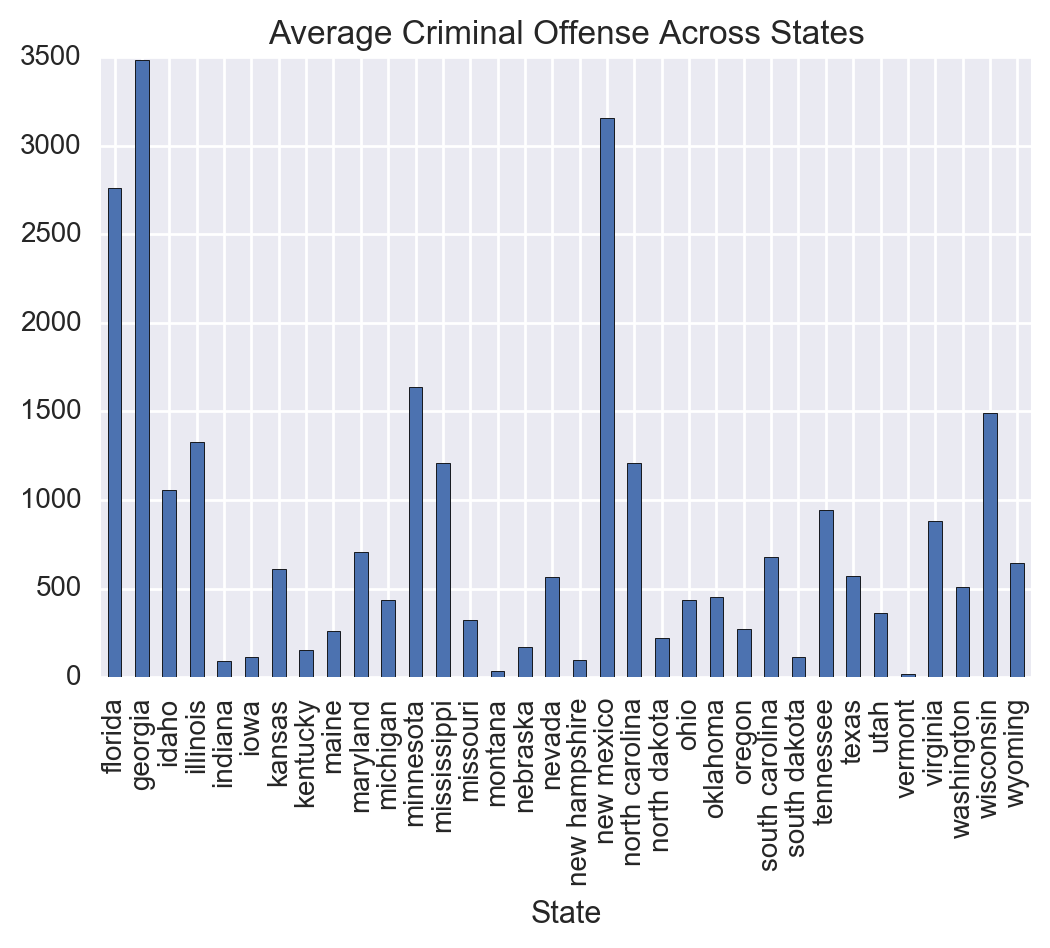

In [15]:
all_by_state=crime.groupby('State').mean()['sum_of_crimes']
all_by_state.plot(kind='bar', title= 'Average Criminal Offense Across States')

In [16]:
top3_avg_crime = all_by_state.sort_values(ascending= False).head(3)
# converting new mexico to string and using title function to capitalize it to New Mexico
print("The top 3 states with highest average are : {} | {} | {} in this particular order.".format(str.capitalize(top3_avg_crime.index.values[0]), str(top3_avg_crime.index.values[1]).title(), str.capitalize(top3_avg_crime.index.values[2])))

The top 3 states with highest average are : Georgia | New Mexico | Florida in this particular order.


In [17]:
#cf.set_config_file(offline=False, world_readable=True, theme='pearl')

In [18]:
#all_by_state.iplot(kind='bubble')

##  The top 3 states with the highest burglary crime rate. 

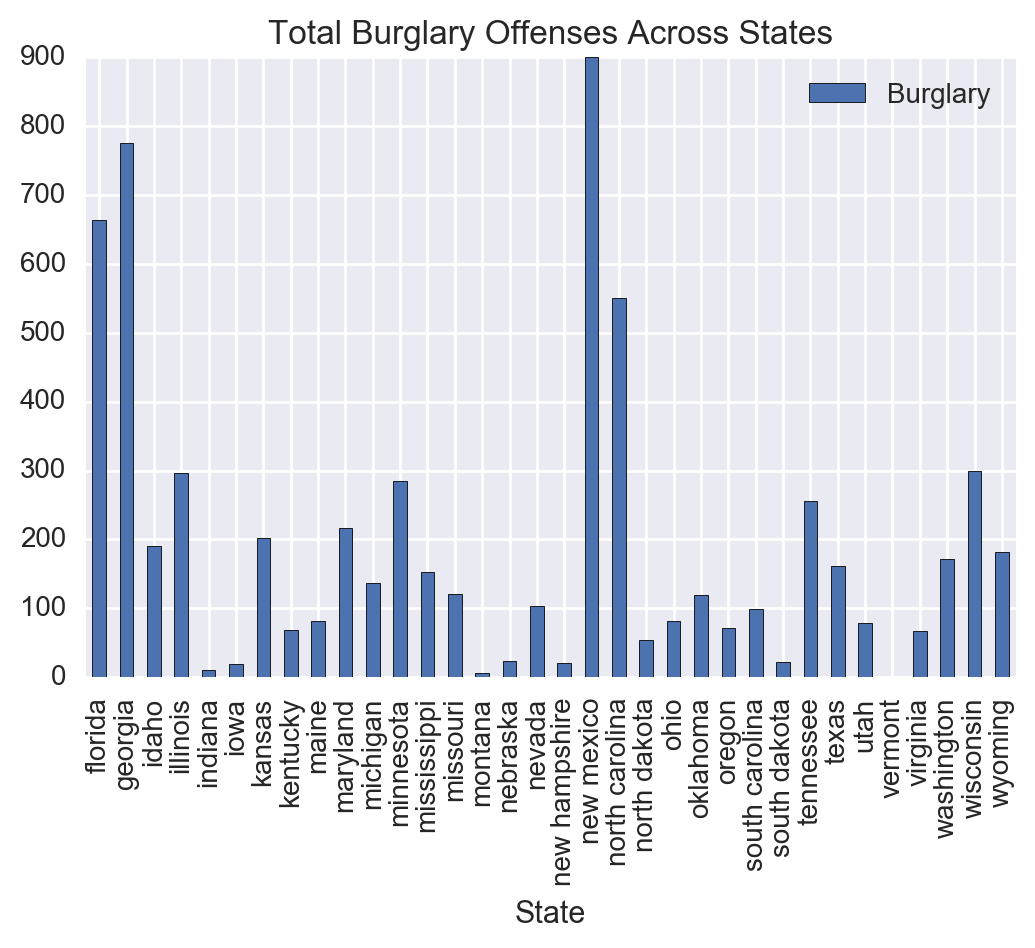

In [19]:
bur_by_state=DataFrame(crime.groupby('State').sum()['Burglary'])
bur_by_state.plot(kind='bar', title= "Total Burglary Offenses Across States")

## Top 3 States with highest Burglary Crime Rate

In [20]:
top3_burglary = bur_by_state['Burglary'].sort_values(ascending= False).head(3)
# converting new mexico to string and using title function to capitalize it to New Mexico
print("The top 3 states with highest burglary are : {} | {} | {} in this particular order.".format(str(top3_burglary.index.values[0]).title(), str(top3_burglary.index.values[1]).title(), str(top3_burglary.index.values[2]).title()))

The top 3 states with highest burglary are : New Mexico | Georgia | Florida in this particular order.


## Are the top 3 states having the highest violent crime rate same as the ones with Burglary crimes?

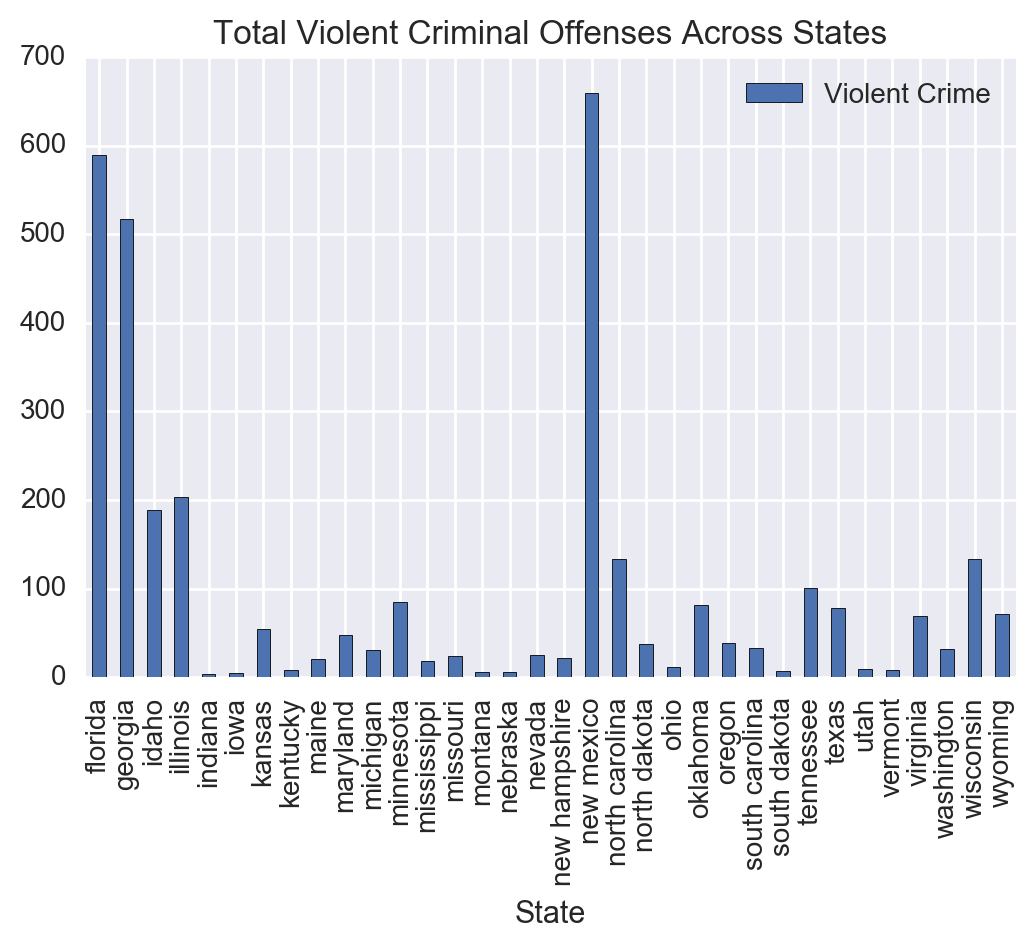

In [21]:
vio_by_state=DataFrame(crime.groupby('State').sum()['Violent Crime'])
vio_by_state.plot(kind='bar', title= "Total Violent Criminal Offenses Across States")

In [22]:
top3_violent = vio_by_state['Violent Crime'].sort_values(ascending= False).head(3)
# converting new mexico to string and using title function to capitalize it to New Mexico
print("The top 3 states with highest burglary are : {} | {} | {} in this particular order.".format(str(top3_violent.index.values[0]).title(), str(top3_violent.index.values[1]).title(), str(top3_violent.index.values[2]).title()))

The top 3 states with highest burglary are : New Mexico | Florida | Georgia in this particular order.


# Indeed New Mexico, Florida and Georgia are the ones with most criminal activities.

## Top 10 states with highest crime rate

## State having the maximum presence in top 10 counties of total crime.

In [83]:
to_sort=DataFrame(crime['sum_of_crimes'])
to_sort['State']=crime['State']
to_sort['county']=crime['code']

top10=to_sort.sort_values('sum_of_crimes',ascending=0).head(10)
result=top10.groupby('State').count()
max_count=result['sum_of_crimes'].max()
max_state=result[result['sum_of_crimes']==max_count].index.values[0]
print('The one has most of the counties in top 10 are from {}.'.format(str.capitalize(max_state)))

The one has most of the counties in top 10 are from Georgia.


# Let's then dive into finding factors that affect crime rate. 

## Is there any significant influence of population, education level, poverty, unemployment as well police staff number on the crime rate of a county?

In [18]:
# add log to crime
crime['sum_of_crimes_log']=crime['sum_of_crimes'].astype(float).apply(np.log10)
crime['police_log']=crime['police'].astype(float).apply(np.log10)
crime['population_log']=pop.apply(np.log10)
crime['poverty_log']=pov.apply(np.log10)
crime['education_log']=edu.apply(np.log10)

# perform regression
result = sm.ols(formula="sum_of_crimes_log ~ police_log+population_log+poverty_log+education_log", data=crime).fit()
print(result.params)
print(result.summary())

Intercept         1.012689
police_log        0.861773
population_log   -0.495484
poverty_log       0.484285
education_log     0.542138
dtype: float64
                            OLS Regression Results                            
Dep. Variable:      sum_of_crimes_log   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     38.14
Date:                Sat, 04 Feb 2017   Prob (F-statistic):           3.89e-15
Time:                        22:38:34   Log-Likelihood:                -15.121
No. Observations:                  59   AIC:                             40.24
Df Residuals:                      54   BIC:                             50.63
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|  

## How does the parole data influence the number of violent crimes in California?

In [19]:
# read original crime data of California
crime_ca_data = pd.read_csv('Crime Ca 1985~2005.csv', skiprows = 4,index_col = 0)
crime_ca_data = crime_ca_data.T
crime_ca_data.index = crime_ca_data.index.astype(int)

crime_ca_data.columns = crime_ca_data.columns.map(lambda x : x.replace(' ','_'))
#if isinstance(x,(str,unicode))else x)

crime_ca_data = crime_ca_data.ix[:,'Violent_Crimes': 'Rape']

# population data
start = datetime.datetime(1985,1,1)
end = datetime.datetime(2015,1,1)
pop_data = data.DataReader("CAPOP", "fred", start, end).resample('A-DEC').mean()
pop_data.index = pop_data.index.year.astype(int)

# prison and parole data
prison = pd.read_csv('prison_population.csv',index_col = 0)

# poverty data
poverty = pd.read_csv('poverty - ca.csv',index_col = 0)

# merge all ariables into dataframe crime_ca
crime_ca = pd.merge(crime_ca_data, prison, left_index=True, right_index = True)\
    .merge(pop_data, left_index=True, right_index = True)\
    .merge(poverty, left_index=True, right_index = True)\

crime_ca = crime_ca.dropna()

# add log to crime
crime_ca['Violent_Crimes_log']=crime_ca['Violent_Crimes'].astype(float).apply(np.log10)
crime_ca['Rape_log']=crime_ca['Rape'].astype(float).apply(np.log10)
crime_ca['Homicide_log']=crime_ca['Homicide'].astype(float).apply(np.log10)

crime_ca['CAPOP_log']=crime_ca['CAPOP'].astype(float).apply(np.log10)
crime_ca['prison_log']=crime_ca['prison'].astype(float).apply(np.log10)
crime_ca['parole_log']=crime_ca['parole'].astype(float).apply(np.log10)
crime_ca['poverty_log']=crime_ca['poverty'].astype(float).apply(np.log10)

# perform regression
result2 = sm.ols(formula="Violent_Crimes_log ~ CAPOP_log+ parole_log+poverty_log", data=crime_ca).fit()
print(result2.params)
print(result2.summary())

Intercept      18.053177
CAPOP_log      -3.818427
parole_log      0.524287
poverty_log     0.532326
dtype: float64
                            OLS Regression Results                            
Dep. Variable:     Violent_Crimes_log   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     30.39
Date:                Sat, 04 Feb 2017   Prob (F-statistic):           5.25e-08
Time:                        22:38:51   Log-Likelihood:                 45.534
No. Observations:                  26   AIC:                            -83.07
Df Residuals:                      22   BIC:                            -78.04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------

## Also how these factors if at all influence the Rape Crimes in California ?

In [20]:
result3 = sm.ols(formula="Rape_log ~ CAPOP_log+ parole_log+poverty_log", data=crime_ca).fit()
print(result3.params)
print(result3.summary())

Intercept      10.608165
CAPOP_log      -1.615962
parole_log      0.142277
poverty_log    -0.000929
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               Rape_log   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     27.09
Date:                Sat, 04 Feb 2017   Prob (F-statistic):           1.42e-07
Time:                        22:38:53   Log-Likelihood:                 58.594
No. Observations:                  26   AIC:                            -109.2
Df Residuals:                      22   BIC:                            -104.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------

## And if these same factors influence the Homicide Crimes in California ?

In [21]:
result4 = sm.ols(formula="Homicide_log ~ CAPOP_log+ parole_log+poverty_log", data=crime_ca).fit()
print(result4.params)
print(result4.summary())

Intercept      13.840312
CAPOP_log      -3.041708
parole_log      0.271650
poverty_log     0.536070
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           Homicide_log   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     11.81
Date:                Sat, 04 Feb 2017   Prob (F-statistic):           8.14e-05
Time:                        22:38:55   Log-Likelihood:                 35.253
No. Observations:                  26   AIC:                            -62.51
Df Residuals:                      22   BIC:                            -57.47
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------

# Let's see the scatter plots between various terms. 

## Violent Crimes in CA with Population

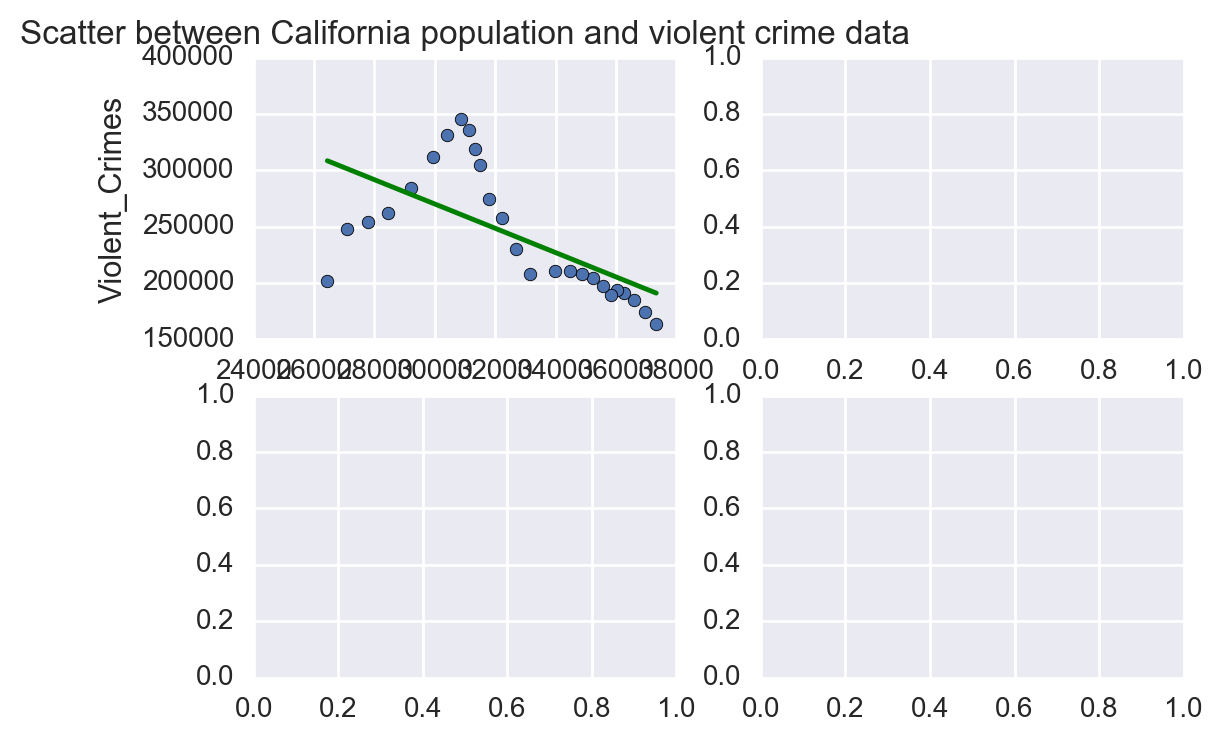

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2)
crime_ca.plot.scatter(x='CAPOP',y='Violent_Crimes',ax=axes[0,0]); 
m, b = np.polyfit(crime_ca['CAPOP'], crime_ca['Violent_Crimes'], 1)
axes[0,0].set_title('Scatter between California population and violent crime data')
axes[0,0].plot(crime_ca['CAPOP'], m*crime_ca['CAPOP'] + b, '-g')

## Violent Crimes in CA with Parole Volume

In [23]:
crime_ca.plot.scatter(x='parole',y='Violent_Crimes',ax=axes[1,0]); 
m, b = np.polyfit(crime_ca['parole'], crime_ca['Violent_Crimes'], 1)
axes[1,0].set_title('Scatter between California parole volumn and violent crime data')
axes[1,0].plot(crime_ca['parole'], m*crime_ca['parole'] + b, '-g')

# Violent Crimes in CA with Poverty Volume

In [24]:
crime_ca.plot.scatter(x='poverty',y='Violent_Crimes',ax=axes[0,1]); 
m, b = np.polyfit(crime_ca['poverty'], crime_ca['Violent_Crimes'], 1)
axes[0,1].set_title('Scatter between California poverty volume and violent crime data')
axes[0,1].plot(crime_ca['poverty'], m*crime_ca['poverty'] + b, '-g')

# Violent Crimes in CA with Prison

In [25]:
crime_ca.plot.scatter(x='prison',y='Violent_Crimes',ax=axes[1,1]); 
m, b = np.polyfit(crime_ca['prison'], crime_ca['Violent_Crimes'], 1)
axes[1,1].set_title('Scatter between California prison and violent crime data')
axes[1,1].plot(crime_ca['prison'], m*crime_ca['prison'] + b, '-g')
plt.show()

## Moving on to other aspects, that might be interesting, we would like to see how crime is being affected by various factors.

### Does Education impact Crimes in general ?

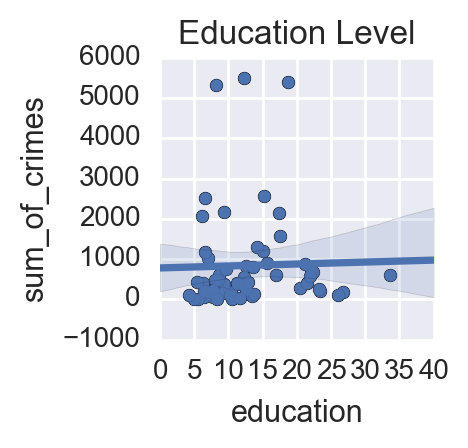

In [26]:
#Q2 sum_of_crimes ~ education
plt.figure()
crime[['education']] = crime[['education']].apply(pd.to_numeric)
f1=plt.subplot(231)
m, b = np.polyfit(crime['education'], crime['sum_of_crimes'], 1)
crime.plot.scatter(x='education',y='sum_of_crimes',ax=f1)
f1.set_title('Education Level')
f1.plot(crime['education'], m*crime['education'] + b, '-g')
sns.regplot(x="education", y="sum_of_crimes", data=crime)

### But what about Poverty ?

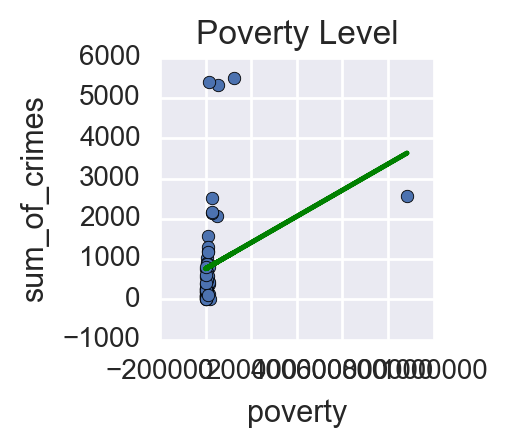

In [27]:
#Q2 sum_of_crimes ~ poverty
f2=plt.subplot(232)
crime["poverty"] = crime["poverty"].str.replace(r'[,]', '').astype('float')
m, b = np.polyfit(crime['poverty'], crime['sum_of_crimes'], 1)
crime.plot.scatter(x='poverty',y='sum_of_crimes',ax=f2)
f2.set_title('Poverty Level')
f2.plot(crime['poverty'], m*crime['poverty'] + b, '-g')

### Population should definitely impact crimes. But does it ?

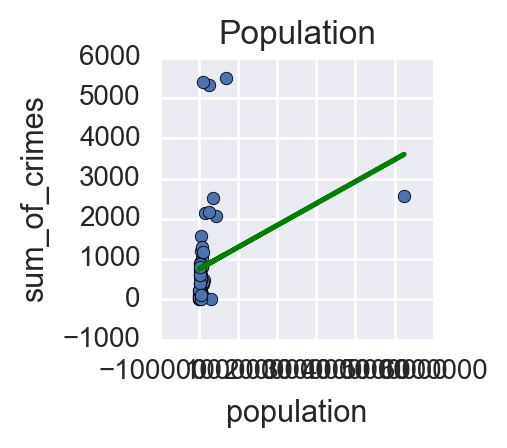

In [28]:
#Q2 sum_of_crimes ~ population
f3=plt.subplot(233)
crime["population"] = crime["population"].str.replace(r'[,]', '').astype('float')
m, b = np.polyfit(crime['population'], crime['sum_of_crimes'], 1)
crime.plot.scatter(x='population',y='sum_of_crimes',ax=f3)
f3.set_title('Population')
f3.plot(crime['population'], m*crime['population'] + b, '-g')

### Umm .... Police ? 

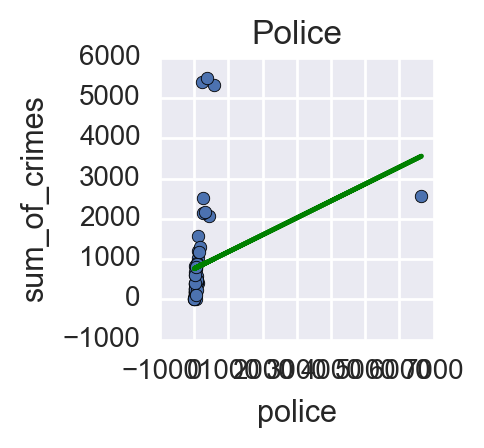

In [29]:
#Q2 sum_of_crimes ~ police
f4=plt.subplot(234)
m, b = np.polyfit(crime['police'], crime['sum_of_crimes'], 1)
crime.plot.scatter(x='police',y='sum_of_crimes',ax=f4)
f4.set_title('Police')
f4.plot(crime['police'], m*crime['police'] + b, '-g')

### How about Unemployment?

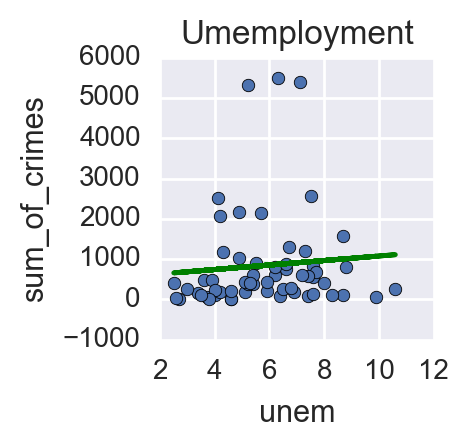

In [30]:
#Q2 sum_of_crimes ~ unemployment
f5=plt.subplot(235)
crime["unem"] = crime["unem"].str.replace(r'[,]', '').astype('float')
m, b = np.polyfit(crime['unem'], crime['sum_of_crimes'], 1)
crime.plot.scatter(x='unem',y='sum_of_crimes',ax=f5)
f5.set_title('Umemployment')
f5.plot(crime['unem'], m*crime['unem'] + b, '-g')
plt.show()

# We would be now interested at looking at a bigger picture about crimes.

dict_keys(['STATE_ABBR', 'STATE_NAME', 'SHAPENUM', 'STATE_FIPS', 'DRAWSEQ', 'RINGNUM', 'SUB_REGION'])


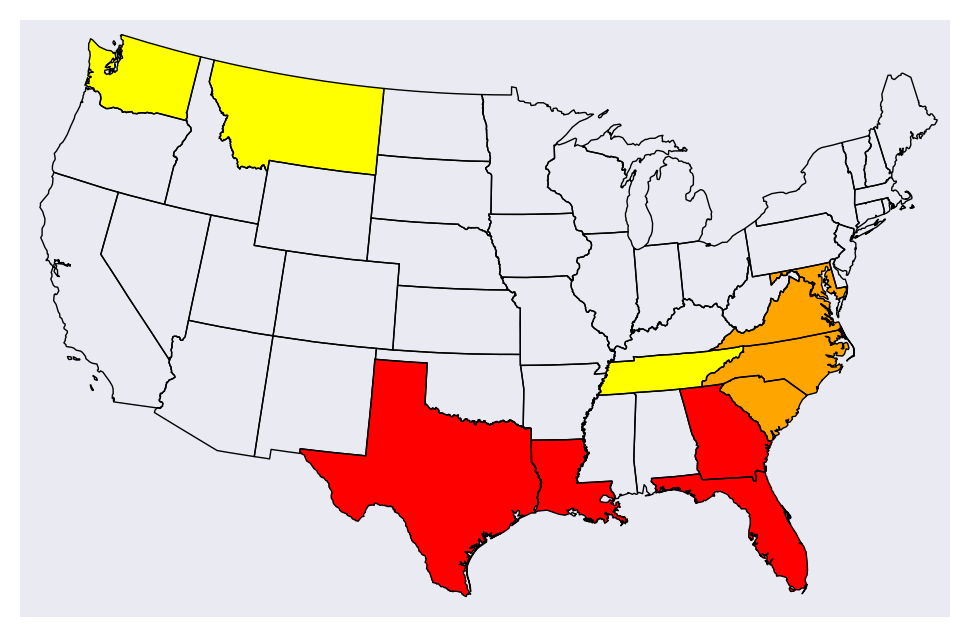

In [31]:
"""
************************************** Extra Mapping states on the Maps ********************************************
"""
plt.figure()
# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# draw state boundaries.
# data from U.S Census Bureau
# http://www.census.gov/geo/www/cob/st2000.html
shp_info = m.readshapefile('states','states',drawbounds=True)

# population density by state from
statenames=[]
cmap = plt.cm.hot # use 'hot' colormap
vmin = 0; vmax = 450 # set range.
print(m.states_info[0].keys())
for shapedict in m.states_info:
    statename = shapedict['STATE_NAME']
    statenames.append(statename)

# cycle through state names, color each one.
ax = plt.gca() # get current axes instance
seg = m.states[statenames.index('Texas')]
poly = Polygon(seg, facecolor='red',edgecolor='red')
ax.add_patch(poly)
seg = m.states[statenames.index('Florida')]
poly = Polygon(seg, facecolor='red',edgecolor='red')
ax.add_patch(poly)
seg = m.states[statenames.index('Georgia')]
poly = Polygon(seg, facecolor='red',edgecolor='red')
ax.add_patch(poly)
seg = m.states[statenames.index('Louisiana')]
poly = Polygon(seg, facecolor='red',edgecolor='red')
ax.add_patch(poly)
seg = m.states[statenames.index('South Carolina')]
poly = Polygon(seg, facecolor='orange',edgecolor='orange')
ax.add_patch(poly)
seg = m.states[statenames.index('Maryland')]
poly = Polygon(seg, facecolor='orange',edgecolor='orange')
ax.add_patch(poly)
seg = m.states[statenames.index('North Carolina')]
poly = Polygon(seg, facecolor='orange',edgecolor='orange')
ax.add_patch(poly)
seg = m.states[statenames.index('Virginia')]
poly = Polygon(seg, facecolor='orange',edgecolor='orange')
ax.add_patch(poly)
seg = m.states[statenames.index('Tennessee')]
poly = Polygon(seg, facecolor='yellow',edgecolor='yellow')
ax.add_patch(poly)
seg = m.states[statenames.index('Washington')]
poly = Polygon(seg, facecolor='yellow',edgecolor='yellow')
ax.add_patch(poly)
seg = m.states[statenames.index('Montana')]
poly = Polygon(seg, facecolor='yellow',edgecolor='yellow')
ax.add_patch(poly)

plt.show()

In [56]:
! pip install cufflinks

  Running setup.py bdist_wheel for cufflinks ... - \ done
  Stored in directory: /Users/arjunberry/Library/Caches/pip/wheels/de/a9/69/f853eccf2c2ac3ba8e7c79f904eedf354fea15d136902cd8b6
  Running setup.py bdist_wheel for colorlover ... - \ done
  Stored in directory: /Users/arjunberry/Library/Caches/pip/wheels/b8/b0/18/76d3f3088cc73950ed1aa44ea074b93ed37309fea57dec78dc
Successfully built cufflinks colorlover
